<h1> LISA Spectrograph data reduction for a nighttime observing run</h1>

This file contains a general data reduction pipeline for the APO LISA spectrograph for data obtained during a nighttime observing run. Each cell can be run by selecting the cell and pressing <i>shit + Enter</i>. Most cells can be run without any adaptions, but others must be customized to suit your specific data. This is explained in the manual.

<strong>This notebook consists of the following sections:</strong>

<a href='#step1'>Step 1: Read in and plot the data</a><br>
<a href='#step2'>Step 2: Flatfield correction</a><br>
<a href='#step3'>Step 3: Wavelength calibration</a><br>

<h2>Before you start</h2>

Before running the data reduction pipeline in this file, the data have to be prepared in a certain way so that the pipeline can handle them. Instructions for these steps can be found in the LISA instruction manual. 

<a id='step1'></a>
<h2>Step 1: Read in and plot the data</h2>

In [1]:
# Cell 1
#
#Start with importing the necessary packages
import os
import sys
import argparse
import numpy as np
import scipy.optimize
import astropy.io.fits as pyfits
import matplotlib 
import matplotlib.pyplot as plt

# Define a function for making a logarithmic gray scale used when plotting several figures
def loggray(x, a=None, b=None):
    """
    Auxiliary function that specifies the logarithmic gray scale.
    a and b are the cutoffs : if not specified, min and max are used
    This function was provided by: 
    http://prancer.physics.louisville.edu/astrowiki/index.php/
    Image_processing_with_Python_and_SciPy#Astronomical_FITS_Files
    """
    if a == None:
        a = np.min(x)
    if b == None:
        b = np.max(x)          
    linval = 10.0 + 990.0 * (x-float(a))/(b-a)
    return (np.log10(linval)-1.0)*0.5 * 255.0

# The following command is needed to allow basic manipulations of the plotted figures and to save the figures
#%matplotlib notebook

# Defining general properties

# Use MaximDL or DS9 to select the pixel of the vertical middle of the frame, where the object spectrum is the strongest.
#midpixel = 520
midpixel = 546

# Vertical range around midpixel where the spectrum is extracted
yrange = 100
yrange_mid = yrange/2
offsetback = 0

# determine whether to extract the background data from above or below the source position
upordown =  midpixel -  1.5*yrange
if upordown < 350:
    midpixelback = midpixel + yrange + offsetback
else: 
    midpixelback = midpixel - yrange - offsetback


# Main data directory (don't use \ in Windows; always use /)
directory = "/Users/nikitasfilosofof/Documents/astronomy-nighttime-run/20220117"

Averaged 5 dark frames


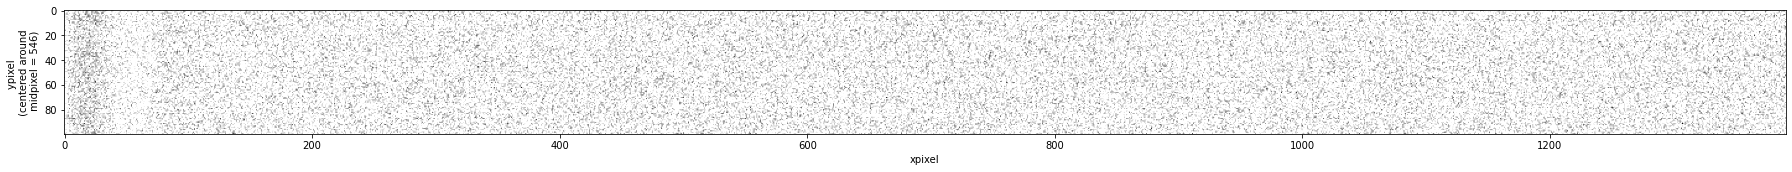

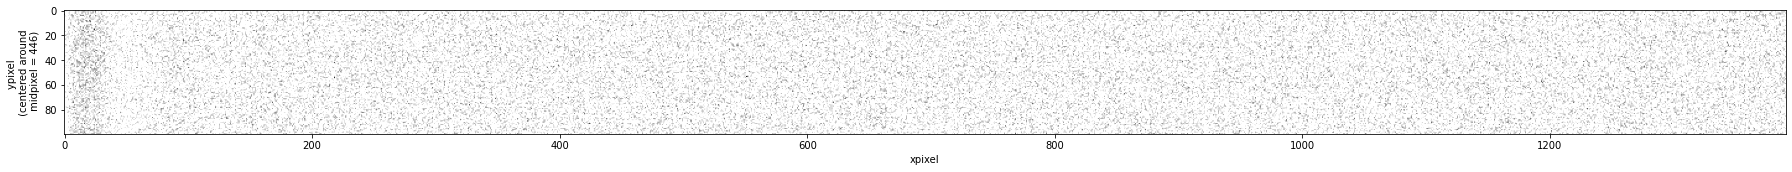

Top panel shows the dark data at the source position; bottom panel at the background position.


In [2]:
# Cell 2
#
# Combining and averaging all the available dark files
# Reading in the dark files; all dark files should be listed in the file "@dark.txt"

# Read in the names of all dark files
num_darkfiles = 0

darkfiles = open(directory + "/@dark_800s.txt","r")
alldarkfiles = darkfiles.readlines( )
alldarkfiles = [x.strip() for x in alldarkfiles] # strip "\n" at the end of eachs line
num_darkfiles = len(alldarkfiles)  

print ("Averaged", num_darkfiles, "dark frames")
    
i=0
dark_data = 0.
dark_backdata = 0.
for df in alldarkfiles:
    i += 1
# Reading in the dark data at the source position    
    inhdulist_dark = pyfits.open(os.path.join(directory,df))
    inhdr_dark = inhdulist_dark[0].header
    dark_data += inhdulist_dark[0].data[int(midpixel-yrange_mid):int(midpixel+yrange_mid)]
# Reading in the dark data at the background position    
    inhdulist_darkback = pyfits.open(os.path.join(directory,df))
    inhdr_darkback = inhdulist_darkback[0].header
    dark_backdata += inhdulist_darkback[0].data[int(midpixelback-yrange_mid):int(midpixelback+yrange_mid)] 

dark_data = dark_data/i
dark_backdata = dark_backdata/i

# Show the master dark image
new_dark_data = loggray(dark_data)
new_dark_min = 0.
new_dark_max = np.mean(new_dark_data)
#new_dark_max = np.max(new_dark_data)

new_dark_backdata = loggray(dark_backdata)
new_dark_min_back = 0.
new_dark_max_back = np.mean(new_dark_backdata)

plt.figure(figsize=(25,3))
plt.imshow(new_dark_data, vmin = new_dark_min, vmax = new_dark_max, cmap ='gray')  
plt.xlabel('xpixel')
plt.ylabel('ypixel \n (centered around \n midpixel = {0})'.format(midpixel))
plt.tight_layout()
plt.show()  

plt.figure(figsize=(25,3))
plt.imshow(new_dark_backdata, vmin = new_dark_min_back, vmax = new_dark_max_back, cmap ='gray')  
plt.xlabel('xpixel')
plt.ylabel('ypixel \n (centered around \n midpixel = {0})'.format(midpixelback))
plt.tight_layout()
plt.show()  

print ("Top panel shows the dark data at the source position; bottom panel at the background position.")

Averaged 3 flat field frames


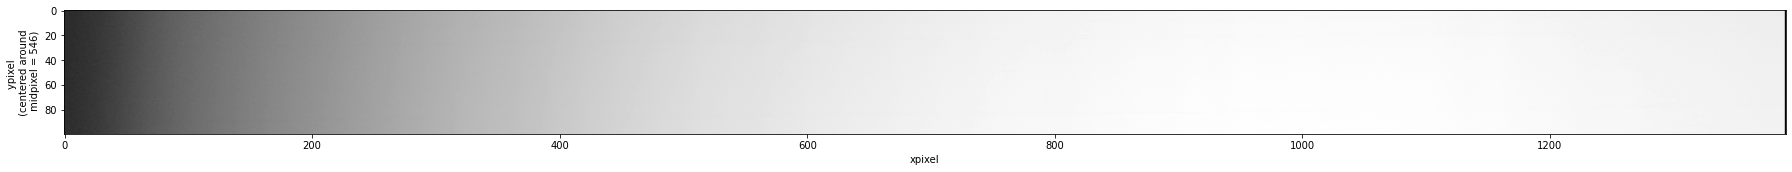

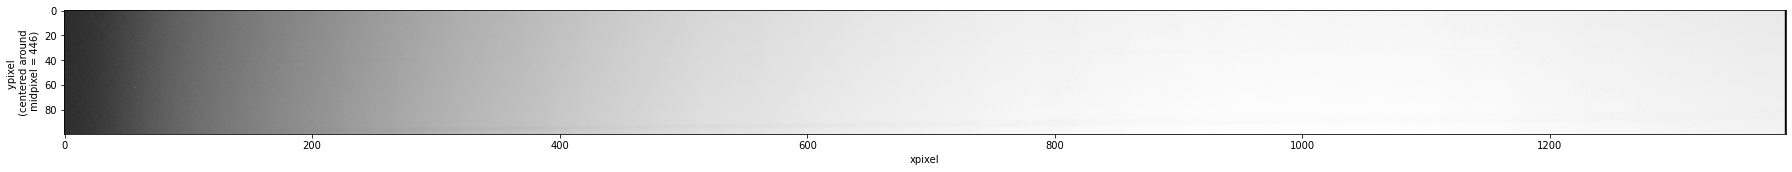

Top panel shows the flat field data at the source position; bottom panel at the background position.


In [3]:
# Cell 3
#
# Combining and averaging all available flat field frames to create a master one
# Reading in the flat field files
# All flat field files should be listed in the file "@flat.txt"

# Read in the names of all dark files
num_flatfiles = 0
flatfiles = open(directory + "/@flat_M32.txt","r")
allflatfiles = flatfiles.readlines( )
allflatfiles = [x.strip() for x in allflatfiles] # strip "\n" at the end of eachs line
num_flatfiles = len(allflatfiles)  

print ("Averaged", num_flatfiles, "flat field frames")
    
i=0
flat_data = 0.
flat_backdata = 0.
for ff in allflatfiles:
    i += 1
# Reading in flat data at source position
    inhdulist_flat = pyfits.open(os.path.join(directory,ff))
    inhdr_flat = inhdulist_flat[0].header
    flat_data += inhdulist_flat[0].data[int(midpixel-yrange_mid):int(midpixel+yrange_mid)]
# Reading in flat data at backgroundposition
    inhdulist_flatback = pyfits.open(os.path.join(directory,ff))
    inhdr_flatback = inhdulist_flatback[0].header
    flat_backdata += inhdulist_flatback[0].data[int(midpixelback-yrange_mid):int(midpixelback+yrange_mid)]
  

flat_data = flat_data/i
flat_backdata = flat_backdata/i

# Show the master flat image
new_flat_data = loggray(flat_data)
new_flat_min = 0.
new_flat_max = np.max(new_flat_data)

plt.figure(figsize=(25,3))
plt.imshow(new_flat_data, vmin = new_flat_min, vmax = new_flat_max, cmap ='gray')  
plt.xlabel('xpixel')
plt.ylabel('ypixel \n (centered around \n midpixel = {0})'.format(midpixel))
plt.tight_layout()
plt.show()  


new_flat_backdata = loggray(flat_backdata)
new_flat_min_back = 0.
new_flat_max_back = np.max(new_flat_backdata)

plt.figure(figsize=(25,3))
plt.imshow(new_flat_backdata, vmin = new_flat_min_back, vmax = new_flat_max_back, cmap ='gray')  
plt.xlabel('xpixel')
plt.ylabel('ypixel \n (centered around \n midpixel = {0})'.format(midpixelback))
plt.tight_layout()
plt.show()  


print ("Top panel shows the flat field data at the source position; bottom panel at the background position.")

Averaged 3 neon lamp spectrum frames


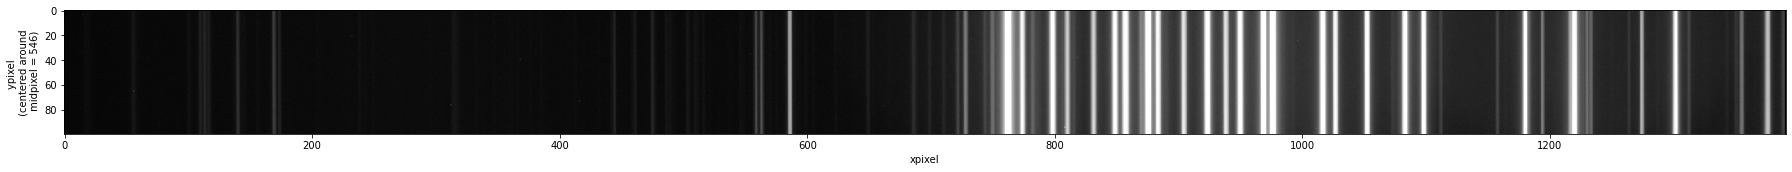

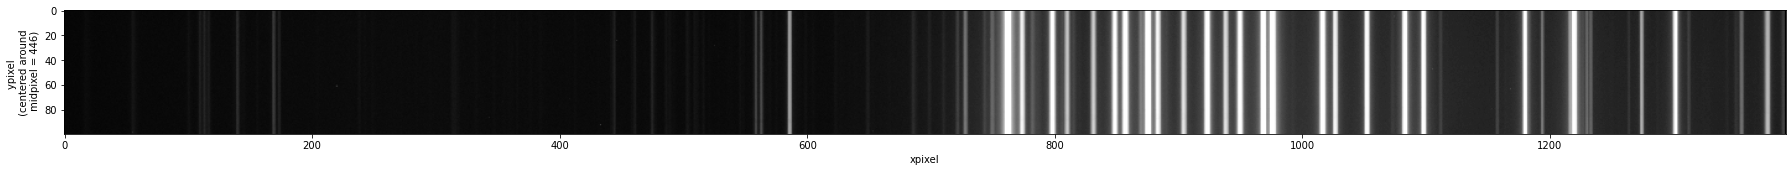

In [4]:
# Cell 4
#
# Combining and averaging all available neon lamp frames to create a master one
# Reading in the neon files
# All neon files should be listed in the file "@neon.txt"

# Read in the names of all dark files
num_neonfiles = 0
neonfiles = open(directory + "/@neon_M32_start_200s.txt","r")
allneonfiles = neonfiles.readlines( )
allneonfiles = [x.strip() for x in allneonfiles] # strip "\n" at the end of eachs line
num_neonfiles = len(allneonfiles)  

print ("Averaged", num_neonfiles, "neon lamp spectrum frames")
    
i=0
neon_data = 0.
neon_data_back = 0.
for nf in allneonfiles:
    i += 1
# Reading in the neon data at the source position    
    inhdulist_wav = pyfits.open(os.path.join(directory,nf))
    inhdr_wav = inhdulist_wav[0].header
    neon_data += inhdulist_wav[0].data[int(midpixel-yrange_mid):int(midpixel+yrange_mid)]
# Reading in the neon data at the background position    
    inhdulist_wav_back = pyfits.open(os.path.join(directory,nf))
    inhdr_wav_back = inhdulist_wav_back[0].header
    neon_data_back += inhdulist_wav_back[0].data[int(midpixelback-yrange_mid):int(midpixelback+yrange_mid)]
  

neon_data = neon_data/i
neon_data_back = neon_data_back/i

# Show the master neon image
new_neon_data = loggray(neon_data)
new_neon_min = 0.
new_neon_max = np.max(new_neon_data)

plt.figure(figsize=(25,3))
plt.imshow(new_neon_data, vmin = new_neon_min, vmax = new_neon_max, cmap ='gray')  
plt.xlabel('xpixel')
plt.ylabel('ypixel \n (centered around \n midpixel = {0})'.format(midpixel))
plt.tight_layout()
plt.show() 

new_neon_data_back = loggray(neon_data_back)
new_neon_min_back = 0.
new_neon_max_back = np.max(new_neon_data_back)

plt.figure(figsize=(25,3))
plt.imshow(new_neon_data_back, vmin = new_neon_min_back, vmax = new_neon_max_back, cmap ='gray')  
plt.xlabel('xpixel')
plt.ylabel('ypixel \n (centered around \n midpixel = {0})'.format(midpixelback))
plt.tight_layout()
plt.show() 

Averaged 5 object frames


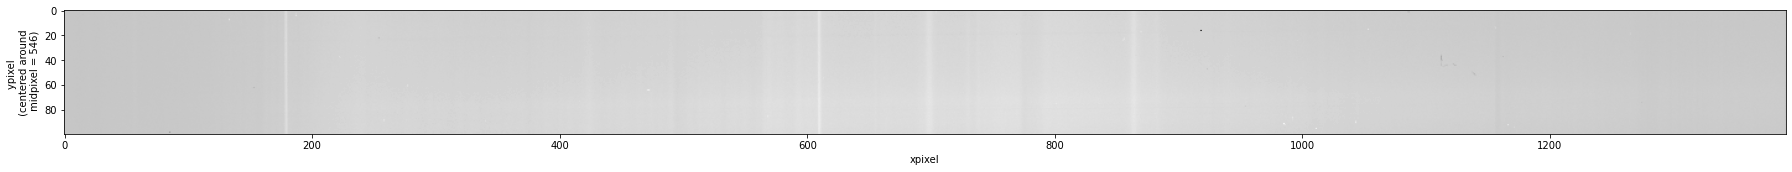

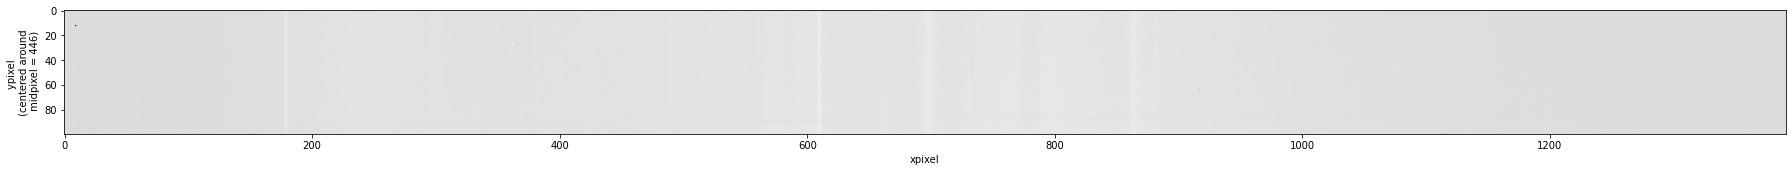

In [5]:
# Cell 5
#
# Combining and averaging all available object frames to create a master one
# Reading in the object files
# All neon files should be listed in the file "@object.txt"

# Read in the names of all dark files
num_objectfiles = 0
objectfiles = open(directory + "/@M32_800s.txt","r")
allobjectfiles = objectfiles.readlines( )
allobjectfiles = [x.strip() for x in allobjectfiles] # strip "\n" at the end of eachs line
num_objectfiles = len(allobjectfiles)  

print ("Averaged", num_objectfiles, "object frames")
    
i=0
object_data = 0.
object_data_back = 0.
for of in allobjectfiles:
    i += 1
# Reading in source data at source position    
    inhdulist = pyfits.open(os.path.join(directory,of))
    inhdr = inhdulist[0].header
    object_data += inhdulist[0].data[int(midpixel-yrange_mid):int(midpixel+yrange_mid)]
# Reading in background data at background position    
    inhdulist_back = pyfits.open(os.path.join(directory,of))
    inhdr_back = inhdulist_back[0].header
    object_data_back += inhdulist_back[0].data[int(midpixelback-yrange_mid):int(midpixelback+yrange_mid)]
  
object_data = object_data/i
object_data_back = object_data_back/i

object_data = object_data - dark_data  # Important step to corrected the science frames for dark current!
object_data_back = object_data_back - dark_backdata 


# Show the master object image
new_object_data = loggray(object_data)
new_object_min = 0.
#new_object_max = np.mean(new_object_data)
new_object_max = np.max(new_object_data)

plt.figure(figsize=(25,3))
plt.imshow(new_object_data, vmin = new_object_min, vmax = new_object_max, cmap ='gray')  
plt.xlabel('xpixel')
plt.ylabel('ypixel \n (centered around \n midpixel = {0})'.format(midpixel))
plt.tight_layout()
plt.show()  


# Show the master object image
new_object_data_back = loggray(object_data_back)
new_object_min_back = 0.
new_object_max_back = np.max(new_object_data_back)

plt.figure(figsize=(25,3))
plt.imshow(new_object_data_back, vmin = new_object_min_back, vmax = new_object_max_back, cmap ='gray')  
plt.xlabel('xpixel')
plt.ylabel('ypixel \n (centered around \n midpixel = {0})'.format(midpixelback))
plt.tight_layout()
plt.show()  

In [6]:
# Cell 6
#
# This is for when master files have been created using other software, like MaximDL; uncomment the code
# All the input files should be placed in one directory
# Insert below the path to the directory
#directory = "/Users/rudy/Desktop/20180629"
#data_file = "Objectmasterfile.fit"     # Filename of object data; it should be dark current corrected
#flat_file = "MasterFlat.fit"        # Filename of master flatfile
#wav_file = "MasterNeon.fit"         # Filename of neon/argon calibration master

# Reading in the source master file
#inhdulist = pyfits.open(os.path.join(directory,data_file))
#inhdr = inhdulist[0].header         # image header
#image_data =  inhdulist[0].data[midpixel-yrange_mid:midpixel+yrange_mid]     # image data

# Reading in the neon master file
#inhdulist_wav = pyfits.open(os.path.join(directory,wav_file))
#inhdr_wav = inhdulist_wav[0].header         # image header
#wav_data =  inhdulist_wav[0].data[midpixel-yrange_mid:midpixel+yrange_mid]     # image data

# Reading in the flat master file
#inhdulist_flat = pyfits.open(os.path.join(directory,flat_file))
#inhdr_flat = inhdulist_flat[0].header         # image header
#flat_data =  inhdulist_flat[0].data[midpixel-yrange_mid:midpixel+yrange_mid]     # image data

# Code when just created the master files; comment out if pre-made master files are available
image_data = object_data
flat_data = flat_data
wav_data = neon_data

image_data_back = object_data_back
flat_data_back = flat_backdata
wav_data_back = neon_data_back

<a id='step2'></a>
<h2> Step 2: Flatfield correction</h2>

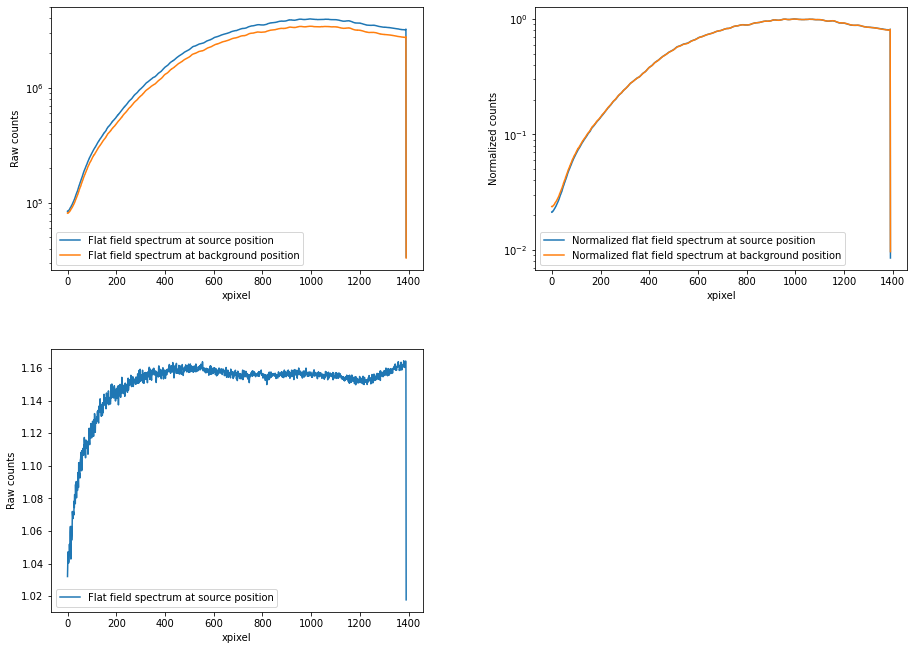

In [7]:
# Cell 7
#
# Plotting flat field spectrum

#%matplotlib notebook

# Extract the spectrum
flatspectrum = np.sum(flat_data, axis=0)
flatspectrum_back = np.sum (flat_data_back, axis=0)

ypix_sensitivity_difference = flatspectrum/flatspectrum_back

# Normalize the flat field spectrum 
flatmaxpix = np.argmax(flatspectrum)      # pixel at which flat field is strongest, not used further right now
flatmaxvalue = np.max(flatspectrum)       # maximum flat field value
flatcorfactor = flatmaxvalue/flatspectrum # flat field correction factor

flatmaxpix_back = np.argmax(flatspectrum_back)      # pixel at which flat field is strongest, not used further right now
flatmaxvalue_back = np.max(flatspectrum_back)       # maximum flat field value
flatcorfactor_back = flatmaxvalue_back/flatspectrum_back # flat field correction factor


plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(np.arange(inhdr['NAXIS1']), flatspectrum, label='Flat field spectrum at source position')
plt.plot(np.arange(inhdr['NAXIS1']), flatspectrum_back, label='Flat field spectrum at background position')
plt.xlabel('xpixel')
plt.ylabel('Raw counts')
plt.yscale('log')
plt.legend()
#plt.tight_layout()

plt.subplot(2,2,2)
plt.plot(np.arange(inhdr['NAXIS1']), 1/flatcorfactor, label='Normalized flat field spectrum at source position')
plt.plot(np.arange(inhdr['NAXIS1']), 1/flatcorfactor_back, label='Normalized flat field spectrum at background position')
plt.xlabel('xpixel')
plt.ylabel('Normalized counts')
plt.yscale('log')
plt.legend()
plt.tight_layout()

plt.subplot(2,2,3)
plt.plot(np.arange(inhdr['NAXIS1']), ypix_sensitivity_difference, label='Flat field spectrum at source position')
plt.xlabel('xpixel')
plt.ylabel('Raw counts')
plt.legend()
#plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3,wspace=0.3)
plt.show()

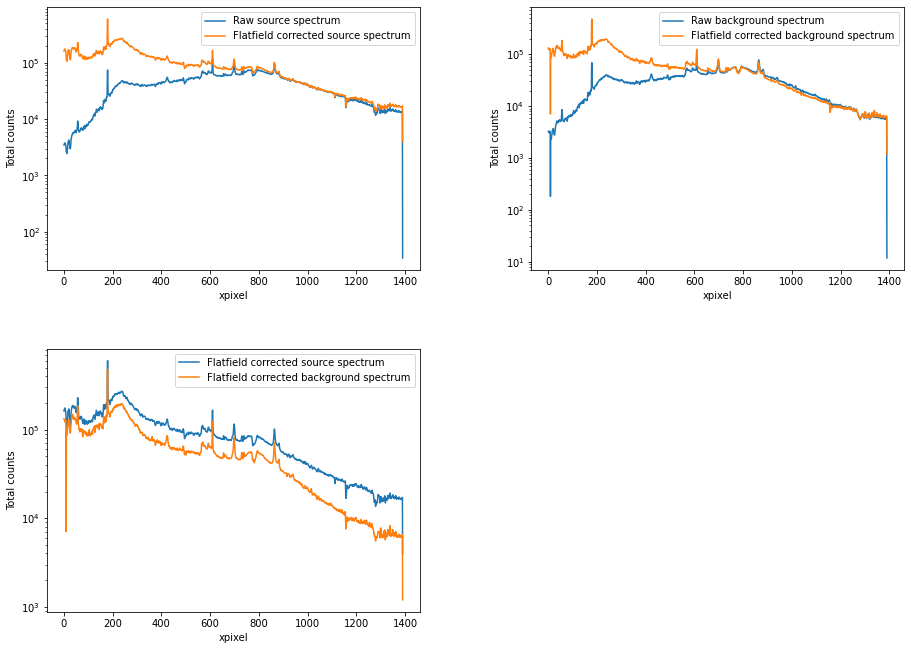

In [8]:
# Cell 8

# Correct the data using the normalized flat field
#flat_mean = np.mean(flat_data, axis=0)
#data_corrected = (image_data) / (flat_data/flat_mean)
data_corrected = (image_data) * (flatcorfactor)
data_corrected_back = (image_data_back) * (flatcorfactor_back) / ypix_sensitivity_difference

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(np.arange(inhdr['NAXIS1']), np.sum(image_data, axis=0), label='Raw source spectrum')
plt.plot(np.arange(inhdr['NAXIS1']), np.sum(data_corrected, axis=0), label='Flatfield corrected source spectrum')
plt.xlabel('xpixel')
plt.ylabel('Total counts')
plt.yscale('log')
plt.legend()
plt.tight_layout()


plt.subplot(2,2,2)
plt.plot(np.arange(inhdr['NAXIS1']), np.sum(image_data_back, axis=0), label='Raw background spectrum')
plt.plot(np.arange(inhdr['NAXIS1']), np.sum(data_corrected_back, axis=0), label='Flatfield corrected background spectrum')
plt.xlabel('xpixel')
plt.ylabel('Total counts')
plt.yscale('log')
plt.legend()
plt.tight_layout()

plt.subplot(2,2,3)
plt.plot(np.arange(inhdr['NAXIS1']), np.sum(data_corrected, axis=0), label='Flatfield corrected source spectrum')
plt.plot(np.arange(inhdr['NAXIS1']), np.sum(data_corrected_back, axis=0), label='Flatfield corrected background spectrum')
plt.xlabel('xpixel')
plt.ylabel('Total counts')
#plt.xlim(100,800)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3,wspace=0.3)

plt.show()

<a id='step3'></a>
<h2> Step 3: Wavelength calibration </h2>

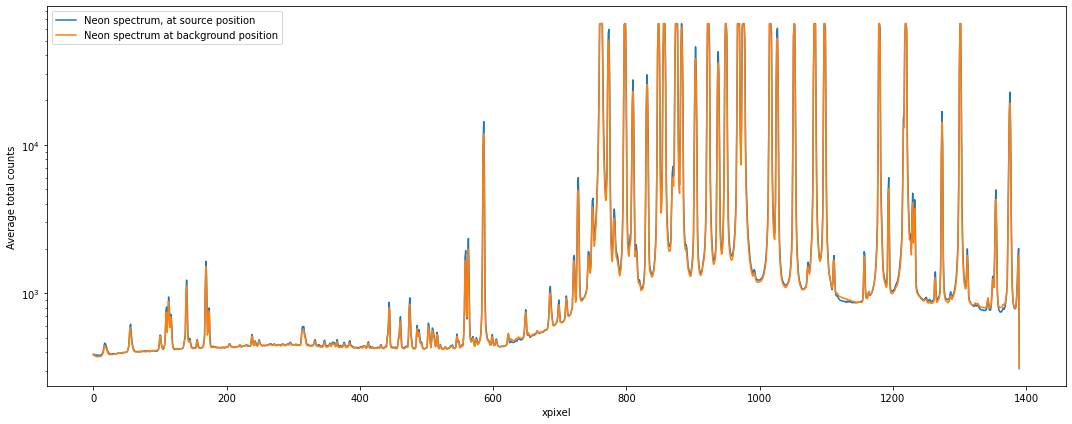

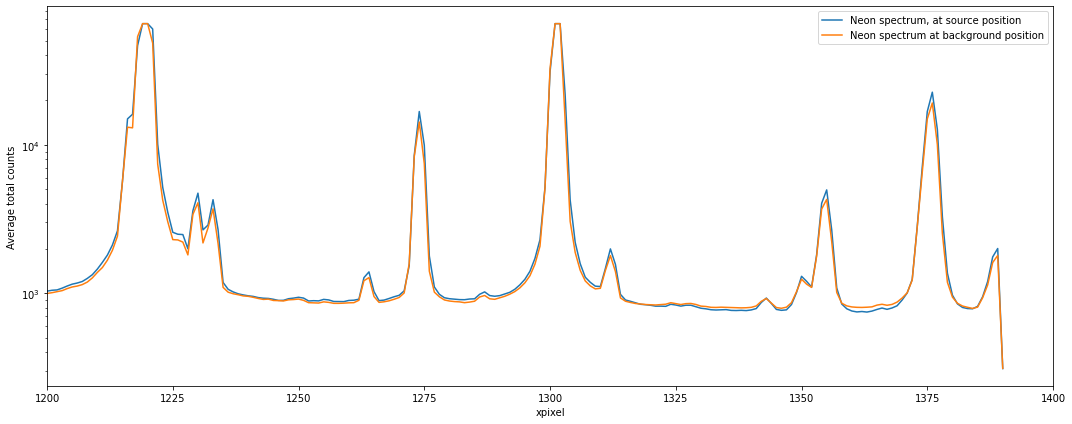

In [9]:
# Cell 9
# 
# Plot the Neon spectrum

# Added '/yrange' to have the counts/pixel so that the saturated lines can easily be seen
neonspectrum = np.sum(wav_data, axis=0)/yrange 
neonspectrum_back = np.sum(wav_data_back, axis=0)/yrange

neonspectrum2 = np.sum(wav_data, axis=0)/yrange 
neonspectrum_back2 = np.sum(wav_data_back, axis=0)/yrange

plt.figure(figsize=(15,6))
plt.plot(np.arange(inhdr['NAXIS1']), neonspectrum, label='Neon spectrum, at source position')
plt.plot(np.arange(inhdr['NAXIS1']), neonspectrum_back, label='Neon spectrum at background position')
plt.xlabel('xpixel')
plt.ylabel('Average total counts')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# Plot a zoom aroud xpixel 700-900 clearly showing that the lines are shifted due to the slanted form of 
# the Neon lines in the 2D image.
plt.figure(figsize=(15,6))
plt.plot(np.arange(inhdr['NAXIS1']), neonspectrum2, label='Neon spectrum, at source position')
plt.plot(np.arange(inhdr['NAXIS1']), neonspectrum_back2, label='Neon spectrum at background position')
plt.xlabel('xpixel')
plt.ylabel('Average total counts')
plt.yscale('log')
plt.xlim(1200,1400)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Cell 10
#
# First, we use an approximate dispersion relation to guess
# the approximate wavelength region covered by each pixel bin

# Find the xpixel location of the strongest line (maximum count)
# at around the mid y pixel.

# Find the approximately center of the 5400.5616 line and specify the begining and the range in xpixel in xl_center
startx = 550
xl_center = startx + np.argmax(wav_data[int(yrange_mid), :][startx:startx+100])
lstart = 5400.5616 - 2.537* (-1 + xl_center) - 0.000022 * (-1 + xl_center)**2
x_pixels = np.arange(inhdr_wav['NAXIS1'])

xl_center_back = startx + np.argmax(wav_data_back[int(yrange_mid), :][startx:startx+100])
lstart_back = 5400.5616 - 2.537* (-1 + xl_center_back) - 0.000022 * (-1 + xl_center_back)**2
x_pixels_back = np.arange(inhdr_wav_back['NAXIS1'])


def wav_to_xpixel(x, wav):    
    return (lstart + 2.537* (-1+x)+0.000022 * (-1+x)**2) - wav

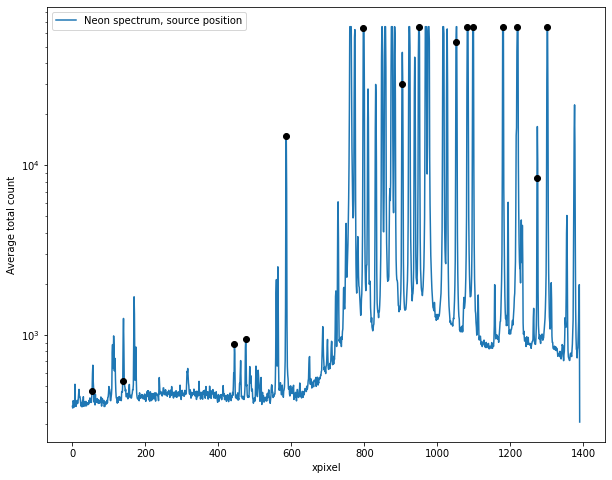

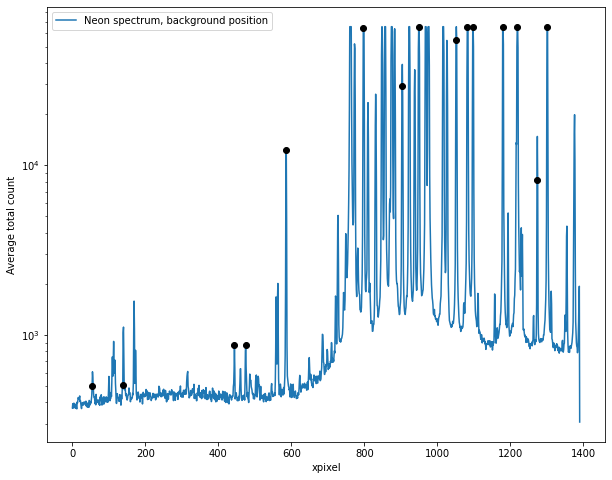

In [11]:
# Cell 11
# This is a list that contains the location of known spectral lines. 
# We will use these to correspond each pixel to the appropriate wavelength.

#cal_lines = {3948.979: 1., 4044.418: 1, 4158.590: 3, 4259.362: 3,   # The first 4 lines are Argon lines
#             5037.7512: 2, 5116.5032: 1, 5400.5616: 10,
#             5944.834: 100, 6217.281: 150, 6334.428: 100,
#             6598.953: 150, 6678.276: 90, 6717.043: 20, 
#             6929.467: 100, 7032.4131: 10, 7173.9381: 10,
#            7245.1666: 100}
#cal_lines = {4044.418: 1, 4158.590: 3, 4259.362: 3,   # The first 3 lines are Argon lines
cal_lines = {4044.418: 1, 4259.362: 3,   # The first 2 lines are Argon lines             
             5037.7512: 2, 5116.5032: 1, 5400.5616: 10,
             5944.834: 100, 6217.281: 150, 6334.428: 100,
             6598.953: 150, 6678.276: 90, 6717.043: 20, 
             6929.467: 100, 7032.4131: 10, 7173.9381: 10,
             7245.1666: 100}



rangepar = int(yrange*2/3)
    
# Let's have a look at the calibration file!
plt.figure(figsize=(10,8))
#plt.plot(np.arange(inhdr['NAXIS1']), wav_data[200, :], label='neon/argon spectrum')
plt.plot(np.arange(inhdr['NAXIS1']), wav_data[rangepar, :], label='Neon spectrum, source position')
plt.xlabel('xpixel')
plt.ylabel('Average total count')
plt.yscale('log')
plt.legend()

# Find the approximate locations of the calibration lines
approx_centers = np.zeros(len(cal_lines), dtype=int)
for i, k in enumerate(cal_lines):
    approx_centers[i] = int(scipy.optimize.root(wav_to_xpixel, x0=[600], args=(k)).x[0])
#    plt.plot((approx_centers[i]), wav_data[200, (approx_centers[i])], ls='', marker='o', c='k')
    plt.plot((approx_centers[i]), wav_data[rangepar, (approx_centers[i])], ls='', marker='o', c='k')
    
plt.show()

# Let's have a look at the calibration file!
plt.figure(figsize=(10,8))
#plt.plot(np.arange(inhdr['NAXIS1']), wav_data[200, :], label='neon/argon spectrum')
plt.plot(np.arange(inhdr['NAXIS1']), wav_data_back[rangepar, :], label='Neon spectrum, background position')
plt.xlabel('xpixel')
plt.ylabel('Average total count')
plt.yscale('log')
plt.legend()

# Find the approximate locations of the calibration lines
approx_centers_back = np.zeros(len(cal_lines), dtype=int)
for i, k in enumerate(cal_lines):
    approx_centers_back[i] = int(scipy.optimize.root(wav_to_xpixel, x0=[600], args=(k)).x[0])
#    plt.plot((approx_centers[i]), wav_data[200, (approx_centers[i])], ls='', marker='o', c='k')
    plt.plot((approx_centers_back[i]), wav_data_back[rangepar, (approx_centers_back[i])], ls='', marker='o', c='k')
    
plt.show()

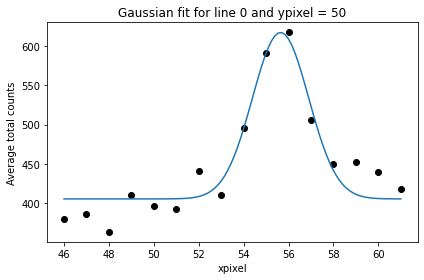

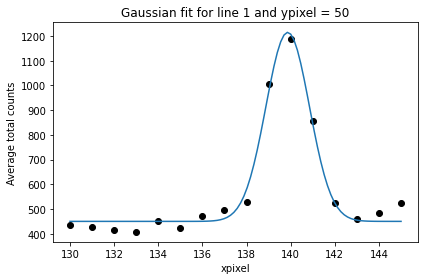

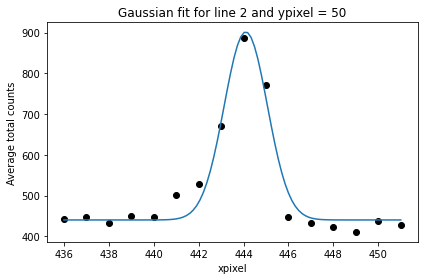

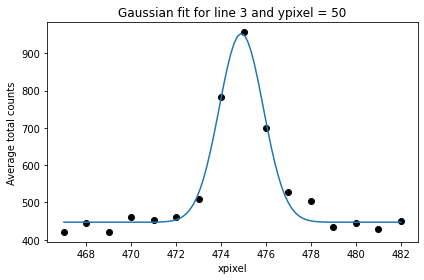

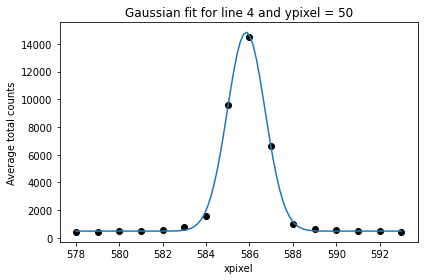

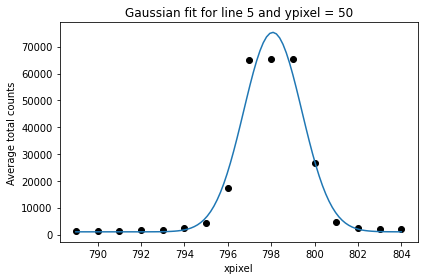

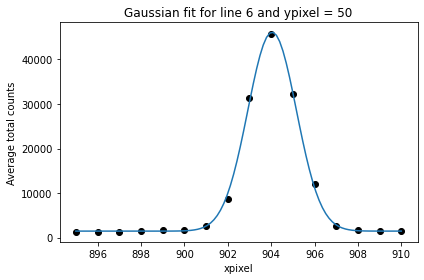

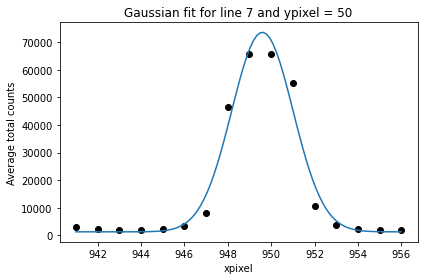

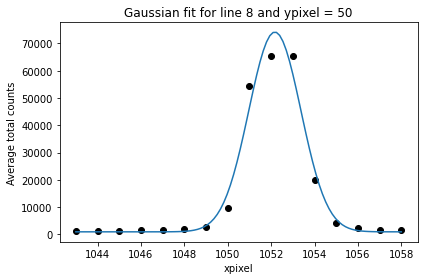

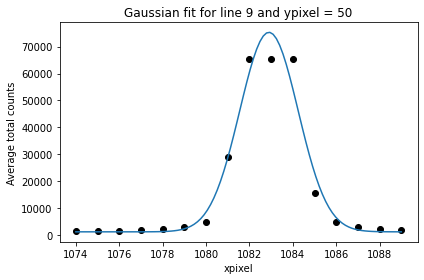

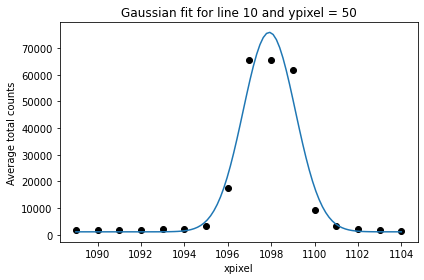

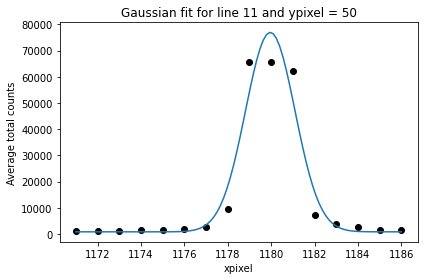

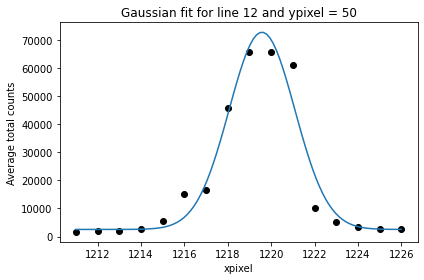

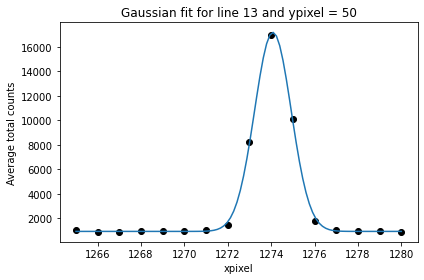

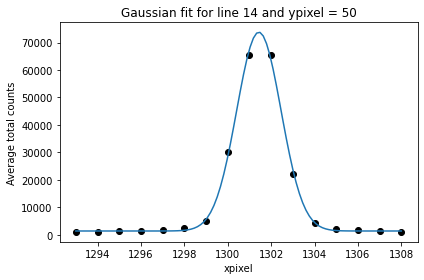

In [12]:
# Cell 12.a

# Define model function to be used to fit spectral lines:
def gauss(x, a, b, c, d):
    return d + a * np.exp(-1. * ((x - c)/b)**2)


polydegree = 4
x_range = 8

# For each ypixel: obtain a fit function lambda(x)
params = []
for ypix in np.arange(yrange):
    x_wav_array = []
    for yline in range(len(cal_lines)):
        # select region around line-estimate
        mid_line_x = approx_centers[yline]
        x = x_pixels[mid_line_x-x_range:mid_line_x+x_range]
        y = wav_data[ypix, :][mid_line_x-x_range:mid_line_x+x_range]
        approx_center = np.argmax(y) + mid_line_x - x_range
        
        # fit gaussian to line to locate linecenter precisely
        try:
            popt, cov = scipy.optimize.curve_fit(gauss, x, y, p0=[np.max(y), 2., approx_center, 100.])
        except:
#            print("No fit for ypix = {0}, yline = {1}. Continue.".format(ypix, yline))
            continue
        
        # add line center in pixels and corresponding wavelength to table 
        x_wav_array.append([popt[2], list(cal_lines.keys())[yline]])
        
        # inspect fit for selected values
        if ypix == yrange_mid:
            plt.figure()
            xplot = np.linspace(np.min(x), np.max(x), 100)
            plt.title('Gaussian fit for line {0} and ypixel = {1}'.format(yline, ypix))
            plt.plot(x, y, marker='o', ls='', c='k')
            plt.plot(xplot, gauss(xplot, *popt))
            plt.xlabel('xpixel')
            plt.ylabel('Average total counts')
            plt.tight_layout()
            plt.show()
    
    # After locating the lines at this ypixel value, make a fit function
    # for the entire wavelength range at this value
    x_wav_array = np.array(x_wav_array)
    y_wavcal = np.polyfit(x_wav_array[:, 0], x_wav_array[:, 1], polydegree)
    params.append(y_wavcal)

params = np.array(params)


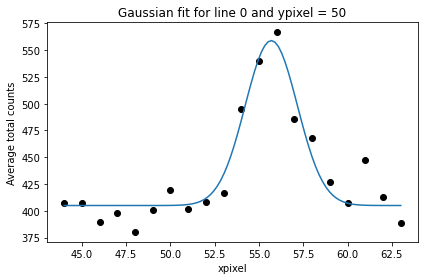

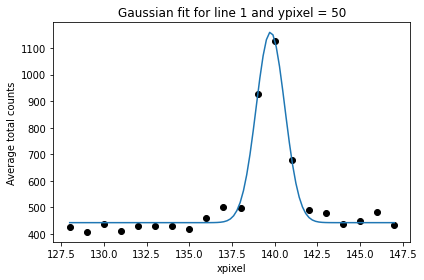

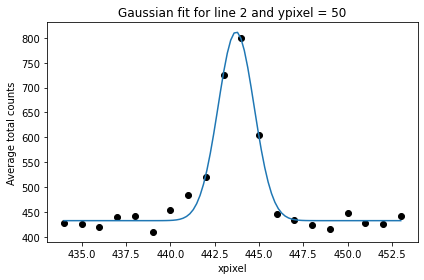

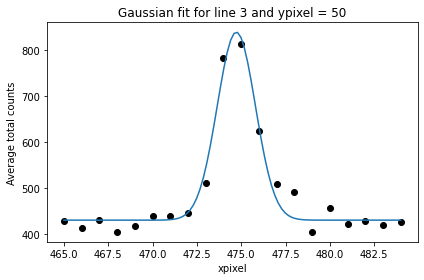

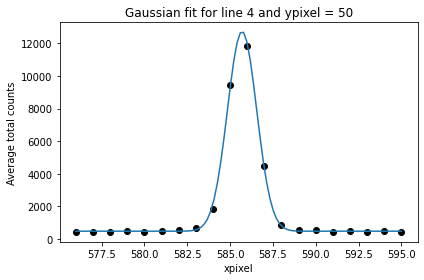

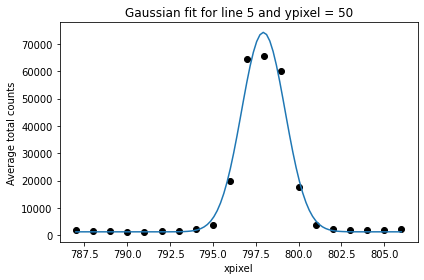

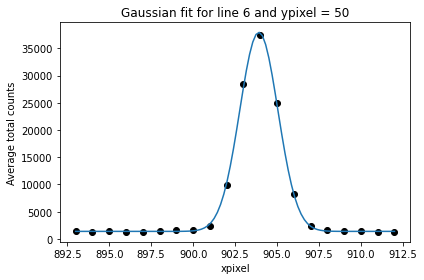

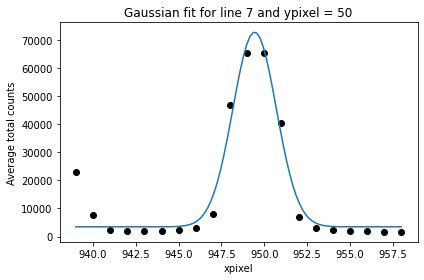

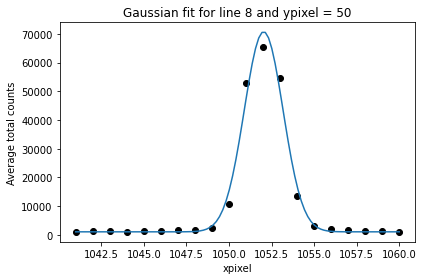

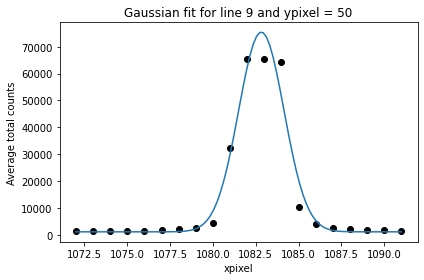

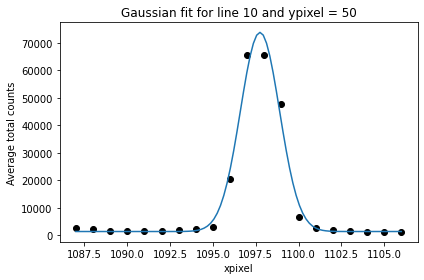

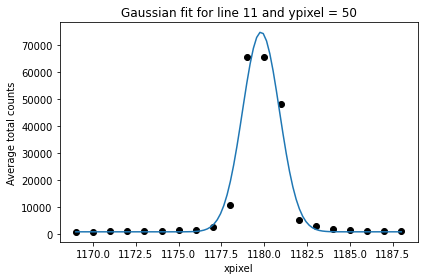

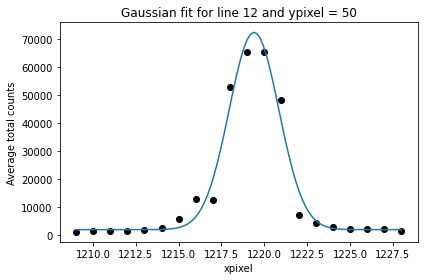

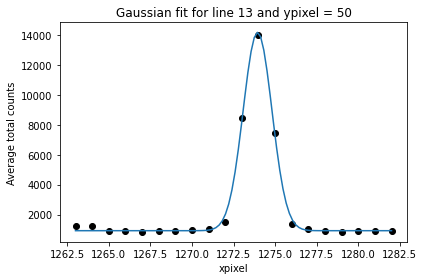

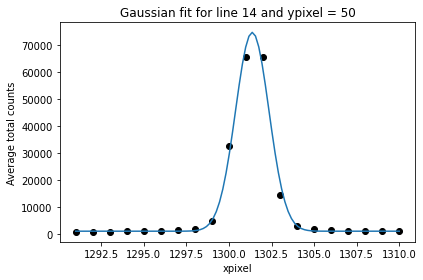

In [13]:
# Cell 12.b

# Define model function to be used to fit spectral lines:
def gauss(x, a, b, c, d):
    return d + a * np.exp(-1. * ((x - c)/b)**2)

x_range = 10

# For each ypixel: obtain a fit function lambda(x)
params_back = []
for ypix in np.arange(yrange):
    x_wav_array = []
    for yline in range(len(cal_lines)):
        # select region around line-estimate
        mid_line_x = approx_centers_back[yline]
        x = x_pixels[mid_line_x-x_range:mid_line_x+x_range]
        y = wav_data_back[ypix, :][mid_line_x-x_range:mid_line_x+x_range]
        approx_center = np.argmax(y) + mid_line_x - x_range
        
        # fit gaussian to line to locate linecenter precisely
        try:
            popt, cov = scipy.optimize.curve_fit(gauss, x, y, p0=[np.max(y), 2., approx_center, 100.])
        except:
#            print("No fit for ypix = {0}, yline = {1}. Continue.".format(ypix, yline))
            continue
        
        # add line center in pixels and corresponding wavelength to table 
        x_wav_array.append([popt[2], list(cal_lines.keys())[yline]])
        
        # inspect fit for selected values
        if ypix == yrange_mid:
            plt.figure()
            xplot = np.linspace(np.min(x), np.max(x), 100)
            plt.title('Gaussian fit for line {0} and ypixel = {1}'.format(yline, ypix))
            plt.plot(x, y, marker='o', ls='', c='k')
            plt.plot(xplot, gauss(xplot, *popt))
            plt.xlabel('xpixel')
            plt.ylabel('Average total counts')
            plt.tight_layout()
            plt.show()
    
    # After locating the lines at this ypixel value, make a fit function
    # for the entire wavelength range at this value
    x_wav_array = np.array(x_wav_array)
    y_wavcal = np.polyfit(x_wav_array[:, 0], x_wav_array[:, 1], polydegree)
    params_back.append(y_wavcal)

params_back = np.array(params_back)




The wavelength calibration function converts each x-y pixel to a wavelength value. The neon lines are slightly slanted, therefore the function depends on both x and y pixel. The function takes the following form (4-th order polynomial):<br>

$\lambda(x, y)$  = a0(y) + a1(y) x + a2(y) x$^2$ + a3(y) x$^3$ + a4(y) x$^4$



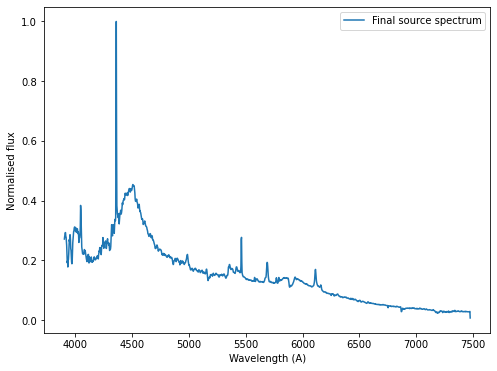

In [14]:
# Cell 13.a

# Apply wavelength calibration and plot final spectrum

# Now we can create a datacube in terms of wavelengths using the lambda(x, y) fit obtained above
objspec = []

# import scipy.interpolate
wavelengths = np.linspace(3793, 7376, 200)
#print (wavelengths)
for ypix in range(yrange):
#    count = image_data[ypix, :]   # this is to plot the raw data, not flat field corrected
    count = data_corrected[ypix, :]

    # function that converts the pixels to wavelength
    # for each ypixel using the previous fit
#    print (ypix, params[ypix])
    pixel_to_wav = np.poly1d(params[ypix])   
    
    # save wavelength converted data for each ypixel
    conv_data = [pixel_to_wav(x_pixels), count]
    objspec.append(conv_data)

    
objspec = np.array(objspec)    # objspec contains wavelength - flux data for each ypixel
lambda_spec = objspec[:, 0][1]
fspec = np.sum(objspec[:, 1], axis=0)   # fspec contains the total flux (summed over ypixels)
fnspec = fspec/np.max(fspec)            # fnspec contains the total normalised flux

# Plot wavelength and flatfield calibrated spectrum
plt.figure(figsize=(8, 6))
plt.plot(lambda_spec, fnspec, label='Final source spectrum')
plt.legend()
plt.xlabel('Wavelength (A)')
plt.ylabel('Normalised flux')
#plt.yscale('log') 

#plt.xlim(6500,6600)
#plt.ylim(0.0,0.3)
plt.show()

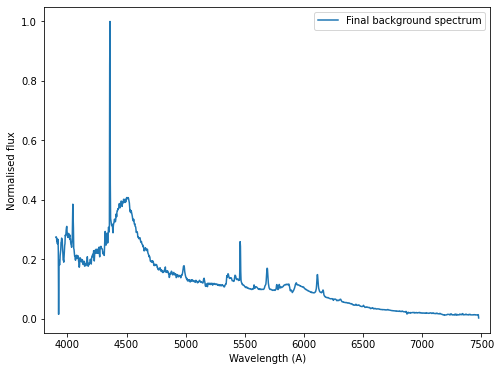

In [15]:
# Cell 13.b

# Apply wavelength calibration and plot final background spectrum

# Now we can create a datacube in terms of wavelengths using the lambda(x, y) fit obtained above
objspec_back = []

# import scipy.interpolate
wavelengths = np.linspace(3793, 7376, 200)
# print wavelengths
for ypix in range(yrange):
#    count = image_data[ypix, :]   # this is to plot the raw data, not flat field corrected
    count = data_corrected_back[ypix, :]

    # function that converts the pixels to wavelength
    # for each ypixel using the previous fit
    pixel_to_wav_back = np.poly1d(params_back[ypix])   
    
    # save wavelength converted data for each ypixel
    conv_data_back = [pixel_to_wav_back(x_pixels), count]
    objspec_back.append(conv_data_back)

    
objspec_back = np.array(objspec_back)    # objspec contains wavelength - flux data for each ypixel
lambda_spec_back = objspec_back[:, 0][1]
fspec_back = np.sum(objspec_back[:, 1], axis=0)   # fspec contains the total flux (summed over ypixels)
fnspec_back = fspec_back/np.max(fspec_back)            # fnspec contains the total normalised flux

# Plot wavelength and flatfield calibrated spectrum
plt.figure(figsize=(8, 6))
plt.plot(lambda_spec_back, fnspec_back, label='Final background spectrum')
plt.legend()
plt.xlabel('Wavelength (A)')
plt.ylabel('Normalised flux')
#plt.yscale('log') 
plt.xlim(np.min(lambda_spec_back)-100, np.max(lambda_spec_back)+100)
#plt.xlim(6500,6600)
plt.show()

In [16]:
# Cell 14

# Write output file

# Save calibrated data to a file if you (in case you want to import it in further analysis scripts)
file_name = directory + '/M32_sourcespectrum.txt'
file_name_back = directory + '/M32_backgroundspectrum.txt'

np.savetxt(file_name, np.column_stack((lambda_spec, fspec)),
            header= 'Wavelength (A) \t Flux')
np.savetxt(file_name_back, np.column_stack((lambda_spec_back, fspec_back)),
            header= 'Wavelength (A) \t Flux')

print('Calibrated source spectrum is saved in file: {0}'.format(file_name))
print('Calibrated background spectrum is saved in file: {0}'.format(file_name_back))


Calibrated source spectrum is saved in file: /Users/nikitasfilosofof/Documents/astronomy-nighttime-run/20220117/M32_sourcespectrum.txt
Calibrated background spectrum is saved in file: /Users/nikitasfilosofof/Documents/astronomy-nighttime-run/20220117/M32_backgroundspectrum.txt


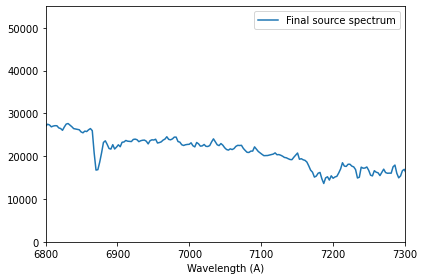

In [28]:
# Cell 15
# Plot source and background spectrum versus wavelength using logarithmic scaling for the y-axis

plt.figure()
plt.plot(lambda_spec, fspec, label='Final source spectrum')
#plt.plot(lambda_spec_back, fspec_back, label='Final background spectrum')
plt.xlabel('Wavelength (A)')
#plt.ylabel('Normalised flux')
#plt.yscale('log')
plt.legend()
plt.xlim(6800,7300)
plt.ylim(0,55000)
plt.tight_layout()
plt.show()

<a id='step4'></a>
<h2>Step 4: Science analysis </h2>

Now the spectrum is calibrated and ready to use for your project science analysis (e.g., spectral line identification and calculating line velocities). Use the cells below to analyse the spectra. Some functions that may be useful are already provided.

In [18]:
# Physical constants that might be useful

c = 299798        # speed of light (km/s)

# Rest wavelengths spectral lines (Angstrom)
L0_HAlpha = 6562.81;
L0_HBeta = 4861.332;
L0_HGamma= 4340.472;
L0_HDelta = 4101.734;
L0_LyAlpha = 1215;
L0_MgII = 2796.5;
L0_OIIIforbid = 4959;
L0_OIIIforbid2 = 5007;
L0_NIIforbid = 6548;
L0_NIIforbid2= 6584;
L0_FraunhoferB = 6867.19;

pi = np.pi

In [19]:
def lambda_to_v(L0, L):
    '''
    Calculate redshift for selected spectral line.
    L0 and L are the rest wavelength and measured line center.
    Returns velocity in km/s.
    '''
    v = c * (L - L0)/L0
    return v


def redshift(L0, L):
    '''
    Calculate line redshift. L0 and L are the rest wavelength 
    and measured line center.
    '''
    z = L0/L - 1. 
    return z

<h3> Calculate redshift and relative velocity of the object using a single spectral line </h3>

This examples uses the H$_{\alpha}$ line, but you can choose other clearly identifyable line depending on the observer object. Note that the velocities need to be corrected for the motion of the Earth (and the solar system)! 

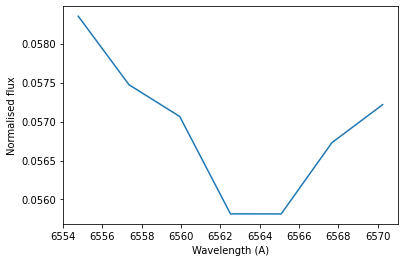

In [20]:
# Select the wavelength region of the line
L0_select = L0_NIIforbid
L0_select = L0_OIIIforbid
L0_select = L0_HAlpha
#L0_select = L0_FraunhoferB

lim_fit_left = L0_select - 10
lim_fit_right = L0_select + 10

i_line = np.where((lambda_spec > lim_fit_left) & (lambda_spec < lim_fit_right))
wav_line = lambda_spec[i_line]
flux_line = fnspec[i_line]

# Plot the selected region for inspection. Adjust line region above if necessary.
plt.figure()
plt.plot(wav_line, flux_line)
plt.xlabel('Wavelength (A)')
plt.ylabel('Normalised flux')
plt.show()

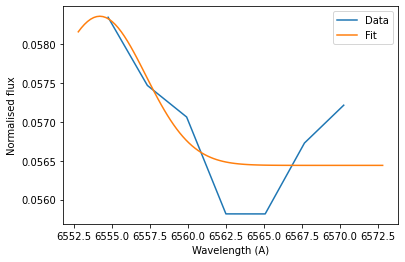

Wavelength center: 	 6554.223104389067 +- 8.288931023100336 Angstrom
Line offset: 	 -8.586895610933425 Angstrom
Linewidth: 	 	 4.254189461408199 +- 7.979082709635767 Angstrom
Redshift: 	 	 0.0013101317233439325 +- -0.0012647276789437 
Velocity: 	 	 392.7748703950643 +- -379.1628286919634 km/s


In [21]:
# Fit the line to obtain linecenter and calculate redshift & velocity
# Adjust the initial fit guess values (p0) to obtain a good fit

popt, pcov = scipy.optimize.curve_fit(gauss, wav_line, flux_line, p0=[np.max(flux_line), 10.0, L0_select, 0.])
errs = np.sqrt(np.diag(pcov))
halpha_wav = np.linspace(lim_fit_left, lim_fit_right, 100)

# Plot the line + fit for inspection
plt.figure()
plt.plot(wav_line, flux_line, label='Data')
plt.plot(halpha_wav, gauss(halpha_wav, *popt), label='Fit')

plt.xlabel('Wavelength (A)')
plt.ylabel('Normalised flux')
plt.legend()
plt.show()

# Print results

z = redshift(L0_HAlpha, popt[2])
z_err = redshift(L0_HAlpha, popt[2]+errs[2]) - z
v = z*c
v_err = z_err*c
print('Wavelength center: \t {0} +- {1} Angstrom'.format(popt[2], errs[2]))
print('Line offset: \t {0} Angstrom' .format(popt[2]-L0_select))
print('Linewidth: \t \t {0} +- {1} Angstrom'.format(popt[1], errs[1]))
print('Redshift: \t \t {0} +- {1} '.format(z, z_err))
print('Velocity: \t \t {0} +- {1} km/s'.format(v, v_err))